In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

from robustbench.utils import load_model
# Load a model from the model zoo
model = load_model(model_name='Gowal2021Improving_R18_ddpm_100m', dataset='cifar10', threat_model='Linf',  model_dir="models")


In [3]:
## get data

In [40]:
import torchvision.datasets as datasets
from torchvision import transforms
import torch
from src.utils.data_utils import create_loaders


transf = transforms.Compose([lambda x: x/1])
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

# cifar_trainset = datasets.CIFAR10(root='data', train=True, download=True, transform=None)
# cifar_testset = datasets.CIFAR10(root='data', train=False, download=True, transform=None)





batch_size = 20
n_workers = 1
data_loader = create_loaders("./data", task_config="CIFAR10",
                             batch_size=batch_size,
                             transform=transf,
                             random_state=0,
                             n_workers=n_workers)


Files already downloaded and verified


In [41]:
images, labels = next(iter(data_loader))
images, labels = images.to(device), labels.to(device)

In [160]:
from adv_lib.attacks import fmn
from tracking import PyTorchModelTrackerSetup
from logging_ import Logger
from tqdm import tqdm
import sys

logger = Logger()
logger.setup(run_id=0)
tracked_model = PyTorchModelTrackerSetup(model, loss_f="CE", logger=logger)  # pytorch model


norm = float("inf")  # will use Linf norm
n_samples = 40

for b, (images, labels) in enumerate(tqdm(data_loader, total=n_samples//batch_size)):

    if b*batch_size >= n_samples:
        break

    tracked_model.setup(images, labels)
    # do attack on selected examples
    results = fmn(tracked_model, images, labels, norm, steps=50)
    tracked_model.log()
    #print(logger.loss_progress)

    #print(sum(map(lambda x: sys.getsizeof(x.storage()), logger.loss_progress)))
#     print(sys.getsizeof(logger.norm_progress.storage()))


100%|██████████| 2/2 [01:41<00:00, 50.99s/it]


In [161]:
results.shape

torch.Size([20, 3, 32, 32])

In [162]:
[x.mean() for x in logger.curr_dict["loss_progress"]]

[0.18496224,
 0.2967093,
 0.4982221,
 0.8320486,
 1.2259119,
 1.5879011,
 1.8741812,
 2.083234,
 2.229856,
 2.316859,
 2.3684402,
 2.3733656,
 2.3434477,
 2.3011036,
 2.2307172,
 2.1561236,
 2.0610878,
 1.9719656,
 1.8757718,
 1.7789272,
 1.7017081,
 1.6234955,
 1.5526606,
 1.4909273,
 1.4253695,
 1.3776684,
 1.3344295,
 1.2856934,
 1.2607132,
 1.2182722,
 1.2086159,
 1.1747879,
 1.1645277,
 1.1311744,
 1.1322222,
 1.1057899,
 1.09872,
 1.0852387,
 1.0799303,
 1.0713274,
 1.0626113,
 1.0612156,
 1.056319,
 1.0519658,
 1.0477186,
 1.0466,
 1.0441452,
 1.0435966,
 1.0410241,
 1.0407655]

In [163]:
model(results).argmax(dim=-1)

tensor([8, 9, 0, 5, 4, 8, 8, 7, 9, 4, 9, 0, 1, 2, 5, 8, 1, 1, 2, 3])

In [164]:
model(images).argmax(dim=-1)

tensor([8, 6, 4, 0, 6, 6, 8, 9, 6, 1, 6, 3, 0, 0, 4, 8, 5, 7, 8, 8])

In [165]:
labels

tensor([8, 6, 4, 0, 6, 6, 8, 9, 6, 1, 6, 3, 0, 0, 2, 8, 5, 7, 8, 8])

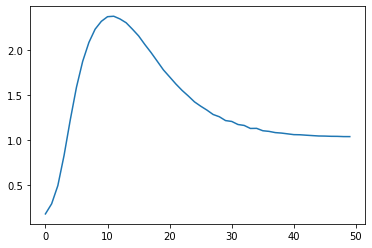

In [166]:
logger.plot_progress(kind="loss")

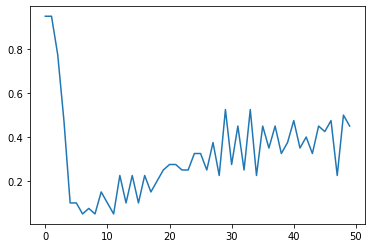

In [167]:
logger.plot_progress(kind="acc")

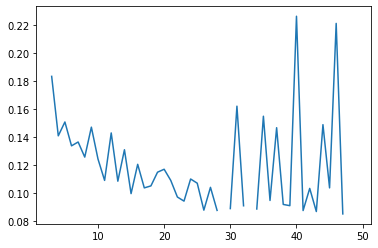

In [173]:
logger.plot_QD()

In [169]:
logger.save_all(force=True)

In [170]:
logger.dict

defaultdict(dict,
            {0: {'norm_progress': array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
                      0.        ],
                     [0.        , 0.04007831, 0.10700542, ..., 0.05925915, 0.02764684,
                      0.05600905],
                     [0.        , 0.05724892, 0.16422555, ..., 0.08851808, 0.04410398,
                      0.08677661],
                     ...,
                     [0.        , 0.03716201, 0.09298959, ..., 0.04862723, 0.03383946,
                      0.05414796],
                     [0.        , 0.03710872, 0.09312296, ..., 0.04869696, 0.03379095,
                      0.05422559],
                     [0.        , 0.03706446, 0.09301183, ..., 0.04863885, 0.03383124,
                      0.05416089]], dtype=float32),
              'loss_progress': array([[1.0361254 , 0.640678  , 0.00133223, ..., 0.02308878, 0.56411695,
                      0.10169575],
                     [1.0361254 , 0.9521005 , 0.

In [174]:
from sweeping import Sweeper

In [178]:
sweeper = Sweeper.from_jsonfile("config.json")

In [179]:
sweeper.config_df

,attack,dataset,loss_f,model,norm,steps,num_steps
0,fmn,CIFAR10,DL,Gowal2021Improving_R18_ddpm_100m,Linf,100,<NA>
1,fmn,CIFAR10,DL,Rade2021Helper_R18_extra,Linf,100,<NA>
2,fmn,CIFAR10,<NA>,Gowal2021Improving_R18_ddpm_100m,L2,100,<NA>
3,fmn,CIFAR10,<NA>,Rade2021Helper_R18_extra,L2,100,<NA>
4,alma,CIFAR10,<NA>,Gowal2021Improving_R18_ddpm_100m,L2,<NA>,100
5,alma,CIFAR10,<NA>,Rade2021Helper_R18_extra,L2,<NA>,100
6,alma,CIFAR10,<NA>,Gowal2021Improving_R18_ddpm_100m,Linf,<NA>,100
7,alma,CIFAR10,<NA>,Rade2021Helper_R18_extra,Linf,<NA>,100


In [ ]:
sweeper.sweep()

attack                          fmn
dataset                     CIFAR10
loss_f                           DL
model      Rade2021Helper_R18_extra
norm                           Linf
steps                           100
Name: 1, dtype: object
Files already downloaded and verified


 20%|██        | 1/5 [01:33<06:12, 93.18s/it]